=== KAGGLE SIMULATION: IDS CONCEPT DRIFT (ARF ADVANCED) ===
--- 1. Loading Data from Kaggle (waqarkha/cicapt-iiot) ---


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:92: DtypeWarning: Columns (68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


Data loaded successfully! Shape: (9536823, 70)

--- 2. Splitting Data by Attack Type for Concept Drift ---
--- 3. Generating 4 Standard Results Charts ---

Baseline Metrics (T1):
{'Stage': 'Baseline', 'Accuracy': 0.9973718791064389, 'Precision': 0.9936708860759493, 'Recall': 0.9936708860759493, 'F1-Score': 0.9936708860759493}

--- 4. Adaptation: Adaptive Random Forest (ARF) ---
>> ARF: Training Background Expert on new data...
>> ARF Performance - Baseline: 0.9606, Expert: 0.7441
>> ARF Final Weights - Baseline: 0.56, Expert: 0.44

--- 5. Comprehensive Analysis (AA, FM, BWT) ---
>> Average Accuracy (AA): 0.9953
>> Forgetting Measure (FM): 0.0000 (Stability: 1.0000)
>> Backward Transfer (BWT): 0.0000

--- Final Performance Summary Table ---
              Accuracy  Precision  Recall  F1-Score
Stage                                              
Baseline        0.9974     0.9937  0.9937    0.9937
Drift-Static    0.9824     0.9730  0.8411    0.9023
ARF-Adaptive    0.9933     0.9922  0.9412 

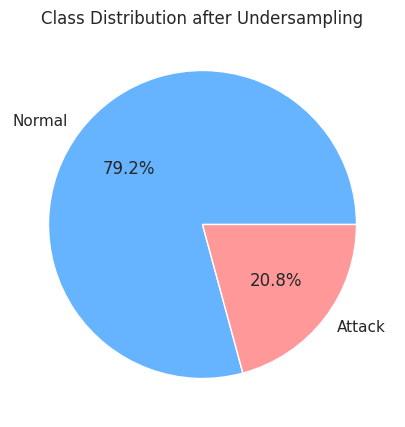

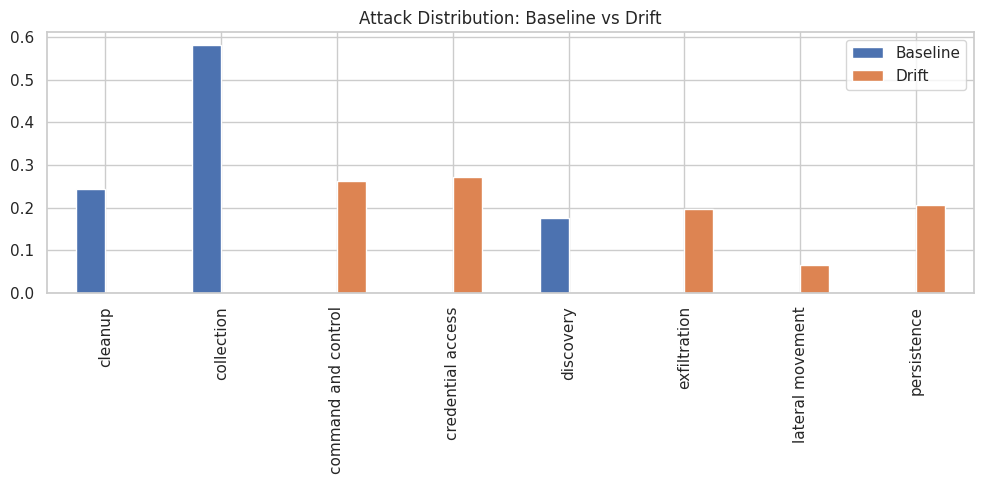

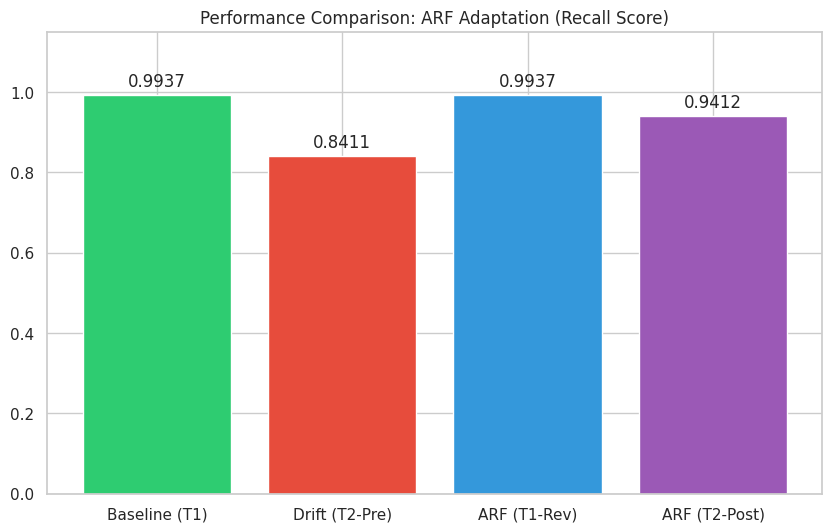

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter
import gc

# Configuration
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

RESULTS_DIR = "results_simulated"
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- CLASS DEFINITION: ADAPTIVE RANDOM FOREST (ARF) LOGIC ---
class AdaptiveRandomForest:
    """
    A simplified implementation of Adaptive Random Forest principles.
    Uses an ensemble of a Baseline Model and a Background Expert Model.
    Weighting is adjusted dynamically to handle Concept Drift.
    """
    def __init__(self, base_model, n_estimators=100):
        self.base_model = base_model
        self.expert_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, random_state=42, n_jobs=-1)
        self.w_base = 1.0
        self.w_expert = 0.0

    def adapt_to_drift(self, X_drift, y_drift, X_buffer, y_buffer):
        print(">> ARF: Training Background Expert on new data...")
        # 1. Train expert solely on the new distribution
        self.expert_model.fit(X_drift, y_drift)
        
        # 2. Advanced Weighting (Adaptive Strategy)
        # Evaluate both on a combined validation set (Buffer + New)
        X_val = pd.concat([X_drift, X_buffer])
        y_val = pd.concat([y_drift, y_buffer])
        
        perf_base = recall_score(y_val, self.base_model.predict(X_val), pos_label=1)
        perf_expert = recall_score(y_val, self.expert_model.predict(X_val), pos_label=1)
        
        print(f">> ARF Performance - Baseline: {perf_base:.4f}, Expert: {perf_expert:.4f}")
        
        # Softmax-like weighting to blend knowledge
        total = perf_base + perf_expert
        if total > 0:
            self.w_base = perf_base / total
            self.w_expert = perf_expert / total
        else:
            self.w_base, self.w_expert = 0.5, 0.5
            
        print(f">> ARF Final Weights - Baseline: {self.w_base:.2f}, Expert: {self.w_expert:.2f}")

    def predict(self, X):
        # Weighted Voting between models
        p_base = self.base_model.predict_proba(X)
        p_expert = self.expert_model.predict_proba(X)
        combined_prob = (self.w_base * p_base) + (self.w_expert * p_expert)
        return np.argmax(combined_prob, axis=1)

def load_data_from_kaggle():
    print("--- 1. Loading Data from Kaggle (waqarkha/cicapt-iiot) ---")
    file_path = "phase2_NetworkData.csv" 
    try:
        df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "waqarkha/cicapt-iiot", file_path)
        print(f"Data loaded successfully! Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None

def split_data_for_drift(df):
    print("\n--- 2. Splitting Data by Attack Type for Concept Drift ---")
    df.columns = df.columns.str.strip()
    df_attacks = df[df['label'] == 1]
    df_normals = df[df['label'] == 0]
    
    # Aggressive undersampling for balanced evaluation
    n_normals_keep = min(len(df_normals), len(df_attacks) * 5)
    df_normals_sampled = df_normals.sample(n=n_normals_keep, random_state=42)
    
    # Drift Strategy
    attack_types = df_attacks['subLabel'].unique()
    group1_types = ['collection', 'cleanup', 'discovery']
    group2_types = [t for t in attack_types if t not in group1_types]
    
    att_g1 = df_attacks[df_attacks['subLabel'].isin(group1_types)]
    norm_g1, norm_g2 = train_test_split(df_normals_sampled, test_size=0.4, random_state=42)
    df_baseline = pd.concat([att_g1, norm_g1]).sample(frac=1, random_state=42)
    
    att_g2 = df_attacks[df_attacks['subLabel'].isin(group2_types)]
    df_drift = pd.concat([att_g2, norm_g2]).sample(frac=1, random_state=42)
    
    return df_baseline, df_drift

def plot_visualizations(df_base, df_drift):
    print("--- 3. Generating 4 Standard Results Charts ---")
    
    # Chart 1: Pie Chart (Distribution)
    plt.figure(figsize=(10, 5))
    counts = df_base['label'].value_counts()
    plt.pie(counts, labels=['Normal', 'Attack'], autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title("Class Distribution after Undersampling")
    plt.savefig(os.path.join(RESULTS_DIR, "eda_pie_chart.png"))
    
    # Chart 2: Attack Type Change (Concept Drift)
    s1 = df_base[df_base['label']==1]['subLabel'].value_counts(normalize=True)
    s2 = df_drift[df_drift['label']==1]['subLabel'].value_counts(normalize=True)
    labels = sorted(list(set(s1.index) | set(s2.index)))
    pd.DataFrame({
        'Baseline': [s1.get(x, 0) for x in labels],
        'Drift': [s2.get(x, 0) for x in labels]
    }, index=labels).plot(kind='bar', figsize=(10, 5))
    plt.title("Attack Distribution: Baseline vs Drift")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "drift_distribution.png"))

    # Chart 3: Feature Drift (flow_duration)
    plt.figure(figsize=(10, 5))
    d1 = df_base[df_base['label']==1]['flow_duration']
    d2 = df_drift[df_drift['label']==1]['flow_duration']
    plt.hist(d1, bins=50, alpha=0.5, label='Baseline', density=True, log=True)
    plt.hist(d2, bins=50, alpha=0.5, label='Drift', density=True, log=True)
    plt.title("Feature Drift Analysis: flow_duration (Log Scale)")
    plt.legend()
    plt.savefig(os.path.join(RESULTS_DIR, "eda_feature_drift.png"))
    plt.close()

def preprocess(df1, df2):
    df1['origin'], df2['origin'] = 'baseline', 'drift'
    df_full = pd.concat([df1, df2], ignore_index=True)
    drop_cols = ['ts', 'Source IP', 'Destination IP', 'Flow ID', 'Label', 'Timestamp']
    df_full.drop(columns=[c for c in drop_cols if c in df_full.columns], inplace=True, errors='ignore')
    df_full.fillna(0, inplace=True)
    for col in df_full.select_dtypes(include=['object']).columns:
        if col not in ['label', 'subLabel', 'subLabelCat', 'origin']:
            df_full[col] = LabelEncoder().fit_transform(df_full[col].astype(str))
    return df_full[df_full['origin'] == 'baseline'].drop(columns=['origin']), \
           df_full[df_full['origin'] == 'drift'].drop(columns=['origin'])

def get_metrics(y_true, y_pred, name):
    return {
        "Stage": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, pos_label=1),
        "Recall": recall_score(y_true, y_pred, pos_label=1),
        "F1-Score": f1_score(y_true, y_pred, pos_label=1)
    }

def main():
    print("=== KAGGLE SIMULATION: IDS CONCEPT DRIFT (ARF ADVANCED) ===")
    df = load_data_from_kaggle()
    if df is None: return
    df_base, df_drift = split_data_for_drift(df)
    plot_visualizations(df_base, df_drift)
    
    df_base_proc, df_drift_proc = preprocess(df_base, df_drift)
    X_base = df_base_proc.drop(columns=['label', 'subLabel', 'subLabelCat'], errors='ignore')
    y_base = df_base_proc['label']
    X_drift = df_drift_proc.drop(columns=['label', 'subLabel', 'subLabelCat'], errors='ignore')
    y_drift = df_drift_proc['label']

    # --- PHASE 1: INITIAL TRAINING ---
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    clf_base = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    clf_base.fit(X_train_base, y_train_base)
    
    # Evaluate Baseline Model on Baseline Test Set
    m_baseline = get_metrics(y_test_base, clf_base.predict(X_test_base), "Baseline")
    print(f"\nBaseline Metrics (T1):\n{m_baseline}")

    # --- PHASE 2: ADAPTIVE RANDOM FOREST (ARF) ---
    print("\n--- 4. Adaptation: Adaptive Random Forest (ARF) ---")
    X_drift_train, X_drift_test, y_drift_train, y_drift_test = train_test_split(X_drift, y_drift, train_size=0.4, random_state=42)
    
    # Buffer for Stability (GEM-like behavior)
    X_buffer = X_train_base.sample(n=len(X_drift_train), random_state=42)
    y_buffer = y_train_base.loc[X_buffer.index]
    
    # Initialize ARF and Adapt
    arf_model = AdaptiveRandomForest(clf_base)
    arf_model.adapt_to_drift(X_drift_train, y_drift_train, X_buffer, y_buffer)
    
    # --- PHASE 3: EVALUATION ---
    print("\n--- 5. Comprehensive Analysis (AA, FM, BWT) ---")
    
    # Evaluate ARF on T1 (Stability) and T2 (Plasticity)
    pred_t1_m2 = arf_model.predict(X_test_base)
    pred_t2_m2 = arf_model.predict(X_drift_test)
    
    m_arf_t1 = get_metrics(y_test_base, pred_t1_m2, "ARF-Stability")
    m_arf_t2 = get_metrics(y_drift_test, pred_t2_m2, "ARF-Adaptive")
    
    # 1. Average Accuracy (AA) - typically calculated over all tasks after learning
    aa = (m_arf_t1['Accuracy'] + m_arf_t2['Accuracy']) / 2
    
    # 2. Forgetting Measure (FM) - Accuracy drop on T1
    fm = m_baseline['Accuracy'] - m_arf_t1['Accuracy']
    
    # 3. Backward Transfer (BWT) - Influence on past task
    bwt = m_arf_t1['Accuracy'] - m_baseline['Accuracy']
    
    print(f">> Average Accuracy (AA): {aa:.4f}")
    print(f">> Forgetting Measure (FM): {fm:.4f} (Stability: {1-fm:.4f})")
    print(f">> Backward Transfer (BWT): {bwt:.4f}")

    # Chart 4: Performance Comparison (Recall focus for IDS)
    plt.figure(figsize=(10, 6))
    drift_recall_pre = recall_score(y_drift, clf_base.predict(X_drift), pos_label=1)
    
    metrics_names = ['Baseline (T1)', 'Drift (T2-Pre)', 'ARF (T1-Rev)', 'ARF (T2-Post)']
    vals = [m_baseline['Recall'], drift_recall_pre, m_arf_t1['Recall'], m_arf_t2['Recall']]
    
    bars = plt.bar(metrics_names, vals, color=['#2ecc71', '#e74c3c', '#3498db', '#9b59b6'])
    plt.title("Performance Comparison: ARF Adaptation (Recall Score)")
    plt.ylim(0, 1.15)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02, f'{bar.get_height():.4f}', ha='center')
    
    plt.savefig(os.path.join(RESULTS_DIR, "performance_comparison_kaggle.png"))
    
    # Create Final Summary Table
    m_drift_pre = get_metrics(y_drift, clf_base.predict(X_drift), "Drift-Static")
    
    summary_df = pd.DataFrame([m_baseline, m_drift_pre, m_arf_t2])
    summary_df.set_index("Stage", inplace=True)
    
    print("\n--- Final Performance Summary Table ---")
    print(summary_df.round(4))
    
    summary_df.to_csv(os.path.join(RESULTS_DIR, "performance_summary.csv"))
    print(f"Results saved to {RESULTS_DIR}")

if __name__ == "__main__":
    main()
